# Schematic Reader Project

The purpose of this project is to create a program that can tally up the different types of valves found on a given mechanical system drawing.

This 'Reader' notebook will take in a PDF of the mechanical drawing, convert it into an image format and extract smaller images of the individual valves in the drawing for classifying and counting. 

#### Import packages

In [1]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from statistics import mode

#### Import system drawing PDF and convert into image

(2339, 3309, 3)


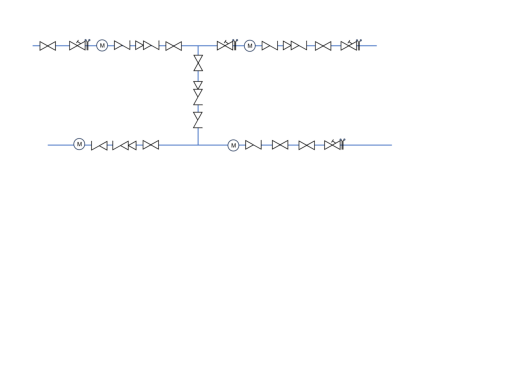

In [2]:
dpi_set = 200

# sch_grid = convert_from_path('./test_sch.pdf', dpi=dpi_set)[0]
# sch_grid = convert_from_path('./T_test_sch.pdf', dpi=dpi_set)[0]
sch_grid = convert_from_path('./H_test_sch.pdf', dpi=dpi_set)[0]



sch_array = np.array(sch_grid)
            
print(sch_array.shape)

plt.imshow(sch_array)
plt.axis('off')
plt.show()

 #### Find the first point in the schematic to start from, we will then follow the line of the drawing to count up all of the valves

In [3]:
x_start = np.argmin(np.all(np.all(sch_array == 255, axis=0), axis=1))
y_start = np.argmin(np.all(sch_array[:,x_start] == 255, axis=1))

# Create a function to find the direction that the line is traveling in

def find_direction(y, x, old_direction = [(0,0)]):

    paths = pd.DataFrame({
        'direction':[(-1,0), (1,0), (0,1), (0,-1)],
        'distance':[np.argmax(np.all(sch_array[:y + 1, x][::-1] == 255, axis = 1)),
                    np.argmax(np.all(sch_array[y:, x] == 255, axis = 1)),
                    np.argmax(np.all(sch_array[y, x:] == 255, axis = 1)),
                    np.argmax(np.all(sch_array[y, :x + 1][::-1] == 255, axis = 1))]
    })    
        
    avoid = [(-x, -y) for (x, y) in old_direction]
    
    paths = paths[~paths.direction.isin(avoid)]
    
    return list(paths[paths.distance > round(dpi_set / 4)].direction)
    
#     else:
#         print('Could not find direction of line.')
    
direction = find_direction(y_start, x_start)[0]

print(f'Start Direction: {direction}')

print(f' Start Position: {y_start, x_start}')

Start Direction: (0, 1)
 Start Position: (242, 151)


#### Find the thickness of the connecting lines in order to centre our start position to account for slight mis-matches in the connecting lines

In [4]:
thickness_slices = {
    (-1, 0): (slice(y_start - round(dpi_set/2), y_start), slice(x_start - round(dpi_set/4), x_start + round(dpi_set/4)),
              slice(None, None)),
    (1, 0): (slice(y_start, y_start + round(dpi_set/2)), slice(x_start - round(dpi_set/4), x_start + round(dpi_set/4)),
             slice(None, None)),
    (0, -1): (slice(y_start - round(dpi_set/4), y_start + round(dpi_set/4)), slice(x_start - round(dpi_set/2), x_start),
              slice(None, None)),
    (0, 1): (slice(y_start - round(dpi_set/4), y_start + round(dpi_set/4)), slice(x_start, x_start + round(dpi_set/2)),
             slice(None, None))
}

# Use the appropriate slice from the thickness_slices dictionary in order to calculate the width in the correct
## axis (dependant on direction of travel)

inspection_box = sch_array[thickness_slices.get(tuple(direction))]

# Find the indices of the top and bottom pixels contained in the connecting line

min_not_white = np.argmin(np.all(inspection_box == 255, axis=2), axis=abs(direction[0]))
max_not_white = len(inspection_box) - 1 - np.argmax(np.any(inspection_box[::-1] != 255, axis=2), axis=abs(direction[0]))

thicknesses = max_not_white - min_not_white
line_thickness = mode(thicknesses)
centre_line = round(mode(min_not_white + max_not_white)/2)

print(f'Line Thickness: {line_thickness} pixels')

# Centre the start position
y_start = y_start + (centre_line - round(dpi_set/4)) * abs(direction[1])
x_start = x_start + (centre_line - round(dpi_set/4)) * abs(direction[0])

sch_array[y_start, x_start] = [255,0,0]

print(f' Centred Start Position: {y_start, x_start}')


# plt.imshow(inspection_box)
# plt.axis('off')
# plt.show()

Line Thickness: 5 pixels
 Centred Start Position: (244, 151)


#### Trace the connecting lines and identify the breaks in the line

In [5]:
# This function flips/rotates the image of the breaks so they all match and stores them for classification

def store(search_area, array_in, direction, break_count = 0):

    name = f'break_{break_count}'
    globals()[name] = array_in[search_area]
    
    if direction == (-1, 0):      
        globals()[name] = np.rot90(array_in[search_area],k=3, axes=(0,1))
    
    elif direction == (1, 0):     
        globals()[name] = np.rot90(array_in[search_area],k=1, axes=(0,1))
    
    elif direction == (0, -1):       
        globals()[name] = np.fliplr(array_in[search_area])
    
    elif direction == (0, 1):      
        globals()[name] = array_in[search_area]
        
    else:
        print('Error - Direction not found.')
        
    
    %store {name}


def trace(y_coord, x_coord, direction, array_in):
    
    # These are the parameters that will need fine tuning to ensure the program splits the image 
    ## in the correct places
    
    min_straight = 7 * line_thickness
    max_gap = 40 * line_thickness
    component_width = 20 * line_thickness
    component_buffer = 7 * line_thickness
    
    new_direction = direction
    array_out = np.copy(array_in)
    local_px = np.zeros((3,3,3))

    break_count = 0
    branches = []
    traversed = []
    
    # While the pixels around the current point aren't all white
    
    while False in np.all(local_px == 255, axis=2):
        
        traversed.append((y_coord, x_coord, new_direction))
        
        local_px = array_out[y_coord - 1: y_coord + 2, x_coord - 1: x_coord + 2, :]
        
        # If the next pixel in the direction of travel is white, check if the line continues shortly after
        
        if np.all(local_px[new_direction[0] + 1, new_direction[1] + 1, :] == 255):
            
            break_y_start = y_coord - component_buffer * new_direction[0]
            break_x_start = x_coord - component_buffer * new_direction[1]
            
            direction_slices = {
                (-1, 0): (slice(None, y_coord + 1), x_coord, slice(None, None)),
                (1, 0): (slice(y_coord + 1, None), x_coord, slice(None, None)),
                (0, -1): (y_coord, slice(None, x_coord + 1), slice(None, None)),
                (0, 1): (y_coord, slice(x_coord + 1, None), slice(None, None))
            }
            
            dir_slice = array_out[direction_slices.get(new_direction)]
            
            
            line_present = [np.all(np.all(dir_slice[i : i + min_straight] == 255, axis=1) == False) 
                   for i in range(len(dir_slice) - min_straight + 1)]
            
            # If the line is present after the break, record its location in relation to the current point
            
            if line_present == []:                    
                line_loc = 0           
            else:
                line_loc = np.argmax(line_present[::(new_direction[0] + new_direction[1])])
                
            
            # If the line continues within a suitable distance, save an image of the break (the valve) and
            ## update the position accordingly
                        
            if line_loc != 0 and line_loc <= max_gap:
                                
                y_coord = y_coord + (line_loc + component_buffer) * new_direction[0]
                x_coord = x_coord + (line_loc + component_buffer) * new_direction[1]
            
                array_out[y_coord, x_coord] = [255,0,0]
                
                break_y_end = y_coord
                break_x_end = x_coord
                
                if break_y_start == break_y_end:
                    search_y = slice(y_coord - round(component_width/2), y_coord + round(component_width/2))
                    search_x = slice(min([break_x_start, break_x_end]), max([break_x_start, break_x_end]))
                
                elif break_x_start == break_x_end:
                    search_y = slice(min([break_y_start, break_y_end]), max([break_y_start, break_y_end]))
                    search_x = slice(x_coord - round(component_width/2), x_coord + round(component_width/2))

                else:
                    print('Error - Schematic lines must be horizontal or vertical.')
                
                
                break_count += 1

                store((search_y, search_x, slice(None,None)), array_in, new_direction, break_count)

                    

            # If the line does not continue after the break, see if it is a change in direction
            
            elif find_direction(y_coord, x_coord, [tuple(new_direction)]):
                
                print('Direction Change.')
                
                # Move the current point into the centre of the line to find available directions
                y_coord = y_coord - round(line_thickness/2) * new_direction[0]
                x_coord = x_coord - round(line_thickness/2) * new_direction[1]
                
                available_directions = find_direction(y_coord, x_coord, [new_direction])
                                
                new_direction = available_directions[0]
                
                # Now move the current position slightly in the direction of travel to avoid detecting the 
                ## previous direction as a branch
                
                y_coord += 2 * line_thickness * new_direction[0]
                x_coord += 2 * line_thickness * new_direction[1]
        
                # If this direction change has already been identified as a branch (i.e. there is a branch 
                ## with a similar start point and with the same direction)
                
                branch_present = [abs(branch[0] - y_coord) < min_straight and 
                                  abs(branch[1] - x_coord) < min_straight and 
                                  branch[2] == new_direction for branch in branches]
                    
                if any(branch_present):
                    branches.pop(branch_present.index(True)) # Remove this from branches
                    print(branches)
                        
                        
                # If there are more than one available directions, add the other paths to the branches list
                
                if len(available_directions) > 1:
                    for i in range(1, len(available_directions)):
                        
                        # If branches list is empty or the branch has not been added or traversed already 
                        ## (i.e. a branch with a similar start point and with the same direction)

                        branch_present = [abs(branch[0] - y_coord) < min_straight and 
                                          abs(branch[1] - x_coord) < min_straight and 
                                          branch[2] == available_directions[i] for branch in branches]

                        path_traversed = [abs(path[0] - y_coord) < min_straight and 
                                          abs(path[1] - x_coord) < min_straight and 
                                          path[2] == available_directions[i] for path in traversed]

                        if branches == [] or (not any(branch_present) and not any(path_traversed)):

                            # Add branch to list inc. x and y coordinates, direction of new branch, the current 
                            ## direction of travel, and the opposite to the current direction of travel

                            branches.append((y_coord + round(line_thickness/2) * (new_direction[0]) + 2 * line_thickness * available_directions[i][0],
                                             x_coord + round(line_thickness/2) * (new_direction[1]) + 2 * line_thickness * available_directions[i][1],
                                             available_directions[i]))
                
                
                # Add path to list of traversed paths
                traversed.append((y_coord, x_coord, new_direction))
            
            else:
                
                # If the end of the line is reached, check the branches list for any branches 
                
                if branches == []:
                
                    print('End of line.')
#                     print('Traversed:')
#                     print(traversed)
                    break
                
                else:
                    print('Branch.')
                    y_coord = branches[0][0]
                    x_coord = branches[0][1]
                    new_direction = branches[0][2]
                    
                    # Add path to list of traversed paths
                    traversed.append(branches[0])
                    
                    # Delete from branches
                    branches.pop(0)
                    print(branches)


                

        else: # If there is no break
                        
            opp_direction = tuple([-i for i in new_direction])
            
            # If there is another valid direction other than the direction of travel (a branch)
            
            if find_direction(y_coord, x_coord, [new_direction, opp_direction]):
                
                available_directions = find_direction(y_coord, x_coord, [new_direction, opp_direction])
                
                for i in range(len(available_directions)):
                    
                    # If branches list is empty or the branch has not been added or traversed already 
                    ## (i.e. a branch with a similar start point and with the same direction)
    
                    branch_present = [abs(branch[0] - y_coord) < min_straight and 
                                      abs(branch[1] - x_coord) < min_straight and 
                                      branch[2] == available_directions[i] for branch in branches]
                    
                    path_traversed = [abs(path[0] - y_coord) < min_straight and 
                                      abs(path[1] - x_coord) < min_straight and 
                                      path[2] == available_directions[i] for path in traversed]
                    
                    if branches == [] or (not any(branch_present) and not any(path_traversed)):

                        # Add branch to list inc. x and y coordinates, direction of new branch, the current 
                        ## direction of travel, and the opposite to the current direction of travel

                        branches.append((y_coord + round(line_thickness/2) * (new_direction[0]) + 2 * line_thickness * available_directions[i][0],
                                         x_coord + round(line_thickness/2) * (new_direction[1]) + 2 * line_thickness * available_directions[i][1],
                                         available_directions[i]))
                        
                        print(branches)

                
            
            
            # And now progress along the line in the direction of travel
                        
            y_coord = y_coord + new_direction[0]
            x_coord = x_coord + new_direction[1]

            array_out[y_coord, x_coord] = [255,0,0]
            
                
                

    
    return array_out, break_count, branches

out, total, branches = trace(y_start, x_start, direction, sch_array)

%store total


Stored 'break_1' (ndarray)
Stored 'break_2' (ndarray)
Stored 'break_3' (ndarray)
Stored 'break_4' (ndarray)
Stored 'break_5' (ndarray)
Stored 'break_6' (ndarray)
[(254, 1254, (1, 0))]
Stored 'break_7' (ndarray)
Stored 'break_8' (ndarray)
Stored 'break_9' (ndarray)
Stored 'break_10' (ndarray)
Stored 'break_11' (ndarray)
Stored 'break_12' (ndarray)
Branch.
[]
Stored 'break_13' (ndarray)
Stored 'break_14' (ndarray)
Stored 'break_15' (ndarray)
[(906, 1264, (0, 1))]
[(906, 1264, (0, 1)), (906, 1244, (0, -1))]
Direction Change.
[(906, 1244, (0, -1))]
Stored 'break_16' (ndarray)
Stored 'break_17' (ndarray)
Stored 'break_18' (ndarray)
Stored 'break_19' (ndarray)
Stored 'break_20' (ndarray)
Branch.
[]
Stored 'break_21' (ndarray)
Stored 'break_22' (ndarray)
Stored 'break_23' (ndarray)
Stored 'break_24' (ndarray)
End of line.
Stored 'total' (int)
